Odessa real estate price predict model

Dear friends, I want to share with you my work on creating a machine learning model that describes the mechanism for the formation of the value of real estate objects, in our case, apartments, and is able to predict it.

At the heart of the work, I used data on more than 6,000 real estate objects, which I received earlier by parsing the site of one of the real estate agencies in the city of Odessa, Ukraine.

My goal was to develop a model that:

- Able to give the most accurate forecast for the value of a property based on its primary features: the location of the property, area, floor and number of floors of the building, the presence of repairs and others.
- The results of the analysis of which can be easily interpreted (for example, the degree of influence of a certain feature on the operation of the algorithm as a whole)

The usefulness of this tool can be to identify undervalued or overvalued real estate objects. And if any object is underestimated in its price, operations with it (purchase, sale) can bring additional profit.

Description of features:

- price - selling price of the apartment
- area - the area of ​​the apartment in square meters
- district - the area where the apartment is located
- floor - the floor of the apartment
- floors - the number of floors in the house
- rooms - number of rooms in the apartment
- type - type of construction project
- cond - general condition of the apartment
- walls - material of the walls of the apartment

A little more detail about the dataset: it represents data on 6657 real estate objects (apartments) in terms of their value (price), location area (district), area (area), number of rooms (rooms), floor (floor) and number of storeys of the building ( floors), a typical construction project (type), the state of the object (cond), the material of the walls (walls) and the basic description of the object (desc) - then let's see how it will be possible to make new features from the descriptive feature.

Loading of all necessary libraries for this kernel

In [252]:
### import all necessary libraries

import numpy as np # linear algebra
from numpy import mean
import pandas as pd # data processing
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
# pd.options.display.max_colwidth = 1000
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import string
from scipy import stats
from scipy.stats.mstats import winsorize
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
# from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
# from sklearn.compose import make_column_transformer, make_column_selector
# from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

PUNCT_TO_REMOVE = string.punctuation
lemmatizer = WordNetLemmatizer()
SEED=2020
cv = KFold(n_splits=10, shuffle=True, random_state=SEED)


Loading of all necessary functions. You can find its description inside of each

In [304]:
def X_y(df):
    '''takes dataframe and returns X and Y'''
    X = df.drop('price', axis=1).reset_index(drop=True)
    y = df.price
    return X,y

def drop_outliers(df):
    """
    Returns clear df without outliers based on IQR method
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in ['price', 'rooms', 'floor', 'floors', 'area']:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR 
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2)
    print(df.loc[multiple_outliers][['price', 'rooms', 'floor', 'floors', 'area']]) # Show the outliers rows
    # Drop outliers
    df = df.drop(multiple_outliers, axis = 0).reset_index(drop=True)
    print('Outliers dropped')
    return df

def model_score(df):
    '''Returns list of dropped outliers and MAE score for next models:
     - gradient boosting regressor
     - linear regressor
     - random forest regressor
    '''

    df_train, df_test = train_test_split(df, test_size=0.3, random_state=SEED)
    print("*************OUTLIERS TO DROP***************")
    df_train = drop_outliers(df_train)
    df_test = drop_outliers(df_test)
    X_train,y_train = X_y(df_train)  
    X_test,y_test = X_y(df_test)  

    gb = GradientBoostingRegressor(random_state=SEED)
    lr = LinearRegression()
    rf = RandomForestRegressor(random_state=SEED)
    # cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # scores_gb = cross_val_score(gb, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv)
    # scores_lr = cross_val_score(lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv)
    # scores_rf = cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv)
    # s_mean_gb = mean(scores_gb)
    # s_mean_lr = mean(scores_lr)
    # s_mean_rf = mean(scores_rf)
    gb.fit(X_train, y_train)
    lr.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    y_pred_gb = gb.predict(X_test)
    y_pred_lr = lr.predict(X_test)
    y_pred_rf = rf.predict(X_test)
    print('*************MODELS RESULT******************')
    # print ('GBR MAE for train DF: %.3f' % (s_mean_gb))
    print ('GB MAE for test DF: %.3f'% (mean_absolute_error(y_test, y_pred_gb)))
    # print ('LR MAE for train DF: %.3f' % (s_mean_lr))
    print ('LR MAE for test DF: %.3f'% (mean_absolute_error(y_test, y_pred_lr)))
    # print ('RF MAE for train DF: %.3f' % (s_mean_rf))
    print ('RF MAE for test DF: %.3f'% (mean_absolute_error(y_test, y_pred_rf)))
    return print('********************************************')

def rf_best_score(df):
    '''Returns best MAE score for Random Forest model with optimized params
    and features affect on final result
    '''
    df_train, df_test = train_test_split(df, test_size=0.3, random_state=SEED)
    X_train,y_train = X_y(df_train)  
    X_test,y_test = X_y(df_test) 
    rf_grid = RandomForestRegressor(random_state=SEED)
    param_grid = {
     'max_depth': [14,15,17,18,19,20,21,22,25],
     'max_features': [4,5,6,7,8, 'auto', 'sqrt'],
     'min_samples_leaf': [2,3,4,5],
     'min_samples_split': [2, 3, 4,5],
     'n_estimators': [160,170,180,190, 200,220,250],
     'max_samples': [0.75, 0.8,0.85,0.9, 0.95]}
    # grid_search = RandomizedSearchCV(rf_grid, param_grid, cv=cv, scoring='neg_mean_absolute_error', n_iter=100)
    grid_search = RandomizedSearchCV(rf_grid, param_grid, cv=cv, scoring='neg_mean_squared_error', n_iter=100)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    rf_best = grid_search.best_estimator_
    # feature importance
    importance = rf_best.feature_importances_
    feat_importances = pd.Series(rf_best.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    y_pred = rf_best.predict(X_test)
    print('************OPTIMAL RANDOM FOREST MODEL RESULT***********')
    print ('RF optimized MAE for test DF: %.3f'% (mean_absolute_error(y_test, y_pred)))
    print ('***************************************')
    df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df = df.sample(50)
    df.plot(kind='bar',figsize=(16,10))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    return rf_best


First of all let's load our dataset and drop all duplicates from it

In [254]:
df= pd.read_csv(r'odessa_apts_prices_en_2020.csv')
df = df.drop_duplicates() ## drop duplicates from dataset

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6657 entries, 0 to 6732
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     6657 non-null   float64
 1   district  6657 non-null   object 
 2   rooms     6514 non-null   float64
 3   floor     6657 non-null   int64  
 4   floors    6657 non-null   float64
 5   area      6641 non-null   float64
 6   type      6657 non-null   object 
 7   cond      6653 non-null   object 
 8   walls     6613 non-null   object 
 9   desc      6486 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 572.1+ KB


You can see that we have 10 features, one of them - target (price) and we'll learn how we can predict it.
Values of some features are missed and also we'll learn how to impute this missed values.

Before we'll define baseline result for our raw dataset and I'll make next steps:

 - dropping all categorial features (Dtype=object)
 - dropping all missed values for numerical features ramained (Dtype=float64, int64)

In [256]:
df_0 = df.drop(['district', 'type', 'cond', 'walls', 'desc'], axis=1).dropna()
df_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6498 entries, 0 to 6732
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   6498 non-null   float64
 1   rooms   6498 non-null   float64
 2   floor   6498 non-null   int64  
 3   floors  6498 non-null   float64
 4   area    6498 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 304.6 KB


We got new temporal dataset with 5 numerical features and 6498 not-null values and now we are ready to get our first result: 

In [257]:
model_score(df_0)

*************OUTLIERS TO DROP***************
         price  rooms  floor  floors   area
4174  350000.0    4.0     23    24.0  215.9
70    600000.0    3.0     22    23.0  200.0
815   135000.0    3.0     22    23.0  148.0
Outliers dropped
         price  rooms  floor  floors   area
6098  183750.0    3.0     26    26.0  147.0
Outliers dropped
*************MODELS RESULT******************
GB MAE for test DF: 17043.824
LR MAE for test DF: 20121.909
RF MAE for test DF: 17469.121
********************************************


Some words about our metric: mean absolute error (MAE) is a measure of errors between paired observations expressing the same phenomenon(Wiki). 

In our case we get MAE USD 17469 as mean error between actual and predicted price of apartments.  

It is difficult to say whether this is a lot or a little. But let's take this result as a basis and try to improve it gradually.

Let's go back to our main dataset and continue working with it. 

At this step, we need to insert missing values into all features (the model cannot work with a feature if it has gaps), and then encode the categorical ones. 

This is necessary so that we can also use them in modeling.

How can we determine the number of values of one feature? It couldn't be easier:

In [258]:
df.district.value_counts()

Primorsky     2734
Suvorovsky    1525
Kievsky       1342
Malinovsky    1056
Name: district, dtype: int64

In exactly the same way we will do it in the future with the rest of the features

Let's encode the values of this feature as follows:

In [259]:
district_category = {'Malinovsky':1, 'Kievsky':2, 'Primorsky':3, 'Suvorovsky':4}
# Mapping 'district' to group
df.loc[:, 'district']=df.loc[:, 'district'].map(district_category)

In the same way we will do it in the future with all our features

The next feature I will work with is the number of rooms in our apartment. Some values of this are missing. First, I want to determine with what other features it correlates. I can do it like this:

In [260]:
df.drop(['type', 'cond', 'walls', 'desc'], axis=1).dropna().corr()

,price,district,rooms,floor,floors,area
price,1.000000,0.053532,0.405550,0.152609,0.163208,0.719058
district,0.053532,1.000000,0.043888,-0.017034,-0.005422,0.052846
rooms,0.405550,0.043888,1.000000,-0.108170,-0.182796,0.652721
floor,0.152609,-0.017034,-0.108170,1.000000,0.675720,0.062924
floors,0.163208,-0.005422,-0.182796,0.675720,1.000000,0.030189
area,0.719058,0.052846,0.652721,0.062924,0.030189,1.000000


If you do not take into account the price of housing, then the area feature would be the best option for area encoding. 

Let's take a look at the average values of this feature depending on the number of rooms:

In [261]:
print ('Mean area for 1-room apts: %.3f m3' % round((df[df['rooms']==1.0]["area"].mean())))
print ('Mean area for 2-rooms apts: %.3f m3' % round((df[df['rooms']==2.0]["area"].mean())))
print ('Mean area for 3-rooms apts: %.3f m3' % round((df[df['rooms']==3.0]["area"].mean())))
print ('Mean area for 4-rooms apts: %.3f m3' % round((df[df['rooms']==4.0]["area"].mean())))
print ('Mean area for missed rooms apts: %.3f m3' % round((df[df['rooms'].isnull()]["area"].mean())))


Mean area for 1-room apts: 43.000 m3
Mean area for 2-rooms apts: 62.000 m3
Mean area for 3-rooms apts: 85.000 m3
Mean area for 4-rooms apts: 114.000 m3
Mean area for missed rooms apts: 192.000 m3


In this case, I decided to enter a new value for the missing data of the variable:

In [262]:

# rooms NaN imputation with new value
df['rooms'].fillna(5, inplace=True)
# df.loc[df['area']<=150, 'rooms'] = df.loc[df['area']<=150, 'rooms'].fillna(5)
# df.loc[df['area']>150, 'rooms'] = df.loc[df['area']>150, 'rooms'].fillna(6)


Only for cosmetic purposes, I convert the values of these indicators to integer values:

In [263]:

df['rooms'] = df['rooms'].astype('int64')
df['floor'] = df['floor'].astype('int64')
df['floors'] = df['floors'].astype('int64')

That's what we got in the end:

In [264]:
df['rooms'].value_counts()


1    2564
2    2072
3    1526
4     352
5     143
Name: rooms, dtype: int64

I will encode the remaining missing feature values as follows:
 - I will replace the missing values of the area with the median value of the feature
 
 - The missing values of the remaining categorical features (I remind you that they are marked with a category in the dataset Dtype=object) I will replace with the value "None":

In [265]:
# area imputation
df["area"].fillna(df['area'].median(), inplace=True)

# cond imputation to None
df["cond"].fillna('None', inplace=True)
# walls imputation to None
df["walls"].fillna('None', inplace=True)

# desc imputation to None
df["desc"].fillna('None', inplace=True)

In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6657 entries, 0 to 6732
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     6657 non-null   float64
 1   district  6657 non-null   int64  
 2   rooms     6657 non-null   int64  
 3   floor     6657 non-null   int64  
 4   floors    6657 non-null   int64  
 5   area      6657 non-null   float64
 6   type      6657 non-null   object 
 7   cond      6657 non-null   object 
 8   walls     6657 non-null   object 
 9   desc      6657 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 572.1+ KB


We have finished working with missing feature values and are now starting to encode categorical features.

Let's explore in detail the meanings of typical housing projects:

In [267]:
df.type.value_counts()

New                   2752
Special project       2008
Old fund               622
Czech                  372
Khrushchevka           307
Stalinka               130
Cellular               104
Belgian                 84
Kharkiv                 83
Under construction      46
Moscow                  45
Guest                   37
Jugoslavsky             31
Private house           20
A small family           6
Renovation               4
After overhaul           3
After makeup             1
After builders           1
Residential clean        1
Name: type, dtype: int64

As part of this work, I decided to combine these values based on the average housing area. I suggest taking a look at the following table:

In [268]:
df.pivot_table(['area', 'price'],['type'], aggfunc='mean').sort_values(by='area')

,area,price
type,,
Guest,28.324324,22343.243243
A small family,40.833333,24666.666667
After builders,42.000000,29000.000000
After overhaul,51.666667,34000.000000
After makeup,53.000000,53000.000000
Under construction,54.135870,68195.152174
Moscow,54.591111,35322.222222
Khrushchevka,55.270684,35296.742671
Jugoslavsky,58.290323,53041.935484


I will combine these values based on the area of housing into 4 main groups: small, medium, big and very big.

In [269]:
    # Mapping type feature depending on apt project area
    df.loc[:,'type'] = df.loc[:,'type'].replace(['New ', 'Czech', 'Khrushchevka', 'Private house', 'Kharkiv', 'Under construction', 'Moscow', 'Jugoslavsky', 'Renovation', 'After overhaul', 'After makeup'], 'Medium')
    df.loc[:,'type'] = df.loc[:,'type'].replace(['Guest', 'A small family', 'After builders'], 'Small')
    df.loc[:,'type'] = df.loc[:,'type'].replace(['Stalinka', 'Residential clean', 'Old fund', 'Cellular', 'Special project'], 'Big')
    df.loc[:,'type'] = df.loc[:,'type'].replace(['Belgian'], 'Very big')
    type_category = {'Small':1, 'Medium':2, 'Big':3, 'Very big':4}
    df.loc[:, 'type'] = df.loc[:,'type'].map(type_category)

Thus, out of 20 values, we will get only 4, which we will further investigate.

We investigate the feature of the condition of the home

In [270]:
df.cond.value_counts()

Renovation                   2329
After builders               1624
Residential clean             915
After overhaul                894
After makeup                  341
Author's design               248
Design Classic                 81
Need. in cap. renovation       75
Need. in cosm. renovation      53
Modern design                  41
Need. in tech. renovation      36
Brick                           5
None                            4
Block-brick                     3
Monolith                        2
Expanded clay-concrete          1
House under construction        1
Aerated concrete                1
Shell rock                      1
Blocky                          1
Building materials              1
Name: cond, dtype: int64

According to the conceptual principle, 21 features will be combined into 5: housing with modern design, after renovation, after builders, need renovation, residental clean.

In [271]:
  # Mapping condition with new categories

df.loc[:,'cond'] = df.loc[:,'cond'].replace(["Author's design", 'Design Classic', 'Modern design', 'Expanded clay-concrete'], 'Design')

df.loc[:,'cond'] = df.loc[:,'cond'].replace(['Renovation', 'After overhaul', 'After makeup'], 'After renovation')

df.loc[:,'cond'] = df.loc[:,'cond'].replace(['After builders', 'Brick', 'Block-brick', "Monolith", 'Blocky', 'House under construction', 'Aerated concrete', 'Shell rock', 'Building materials', 'None'], 'After builders') 

df.loc[:,'cond'] = df.loc[:,'cond'].replace(['Need. in cap. renovation', 'Need. in cosm. renovation', 'Need. in tech. renovation'], 'Need renovation') 

cond_category = {'After renovation':1, 'After builders':2, 'Need renovation':3, 'Residential clean':4, 'Design':5}
df.loc[:,'cond']= df.loc[:,'cond'].map(cond_category)

This is what we have as a result.

In [272]:
df.cond.value_counts()

1    3564
2    1643
4     915
5     371
3     164
Name: cond, dtype: int64

In exactly the same way, we process the values of the materials from which the walls of the appartments are made.

In [273]:
df.walls.value_counts()

Brick                     2536
Monolith                  1291
Shell rock                 873
Block-brick                624
Panel                      618
Aerated concrete           359
Foam concrete              167
Blocky                      48
None                        44
Expanded clay-concrete      43
Shell brick                 24
Concrete                     8
Metal-plastic                6
Metalwork                    5
Plastic                      4
Reinforced concrete          2
Wood                         2
Reed, dranka                 1
Mixed                        1
Silicate brick               1
Name: walls, dtype: int64

In [274]:
    # Bundle walls with new categories
    df.loc[:,'walls'] = df.loc[:,'walls'].replace(['Metal-plastic', 'Metalwork', 'Plastic', "Wood", 'Mixed', 'Reed, dranka ', 'None'], 'Other')

    walls_category = {'Brick':1, 'Silicate brick':1, 'Monolith':2, 'Concrete':2, 'Reinforced concrete':2, 'Shell rock':3, 'Shell brick':3, 'Block-brick':4, 'Blocky':4,
                     'Panel': 5, 'Aerated concrete':6, 'Foam concrete':6, 'Expanded clay-concrete': 6, 'Other':7}
    df.loc[:,'walls']=df.loc[:,'walls'].map(walls_category)

And here is the result:

In [275]:
df.walls.value_counts()

1    2537
2    1301
3     897
4     672
5     618
6     569
7      63
Name: walls, dtype: int64

Let's take a small slice of the result by removing the descriptive characteristic and training the model on the available data:

In [276]:
df_1 = df.drop(['desc'], axis=1)
df_1.head()

,price,district,rooms,floor,floors,area,type,cond,walls
0,95000.0,1,3,10,10,100.0,2,1,1
1,55000.0,2,2,5,14,76.0,2,2,1
2,85000.0,3,3,7,16,77.0,2,1,1
3,35000.0,2,1,11,15,40.0,2,1,2
4,61000.0,2,4,3,10,78.0,2,1,1


In [277]:
model_score(df_1)

*************OUTLIERS TO DROP***************
         price  rooms  floor  floors   area
4174  350000.0      4     23      24  215.9
Outliers dropped
         price  rooms  floor  floors   area
815   135000.0      3     22      23  148.0
5889  236040.0      3     20      20  167.2
3739  130000.0      5     20      20  155.0
6098  183750.0      3     26      26  147.0
Outliers dropped
*************MODELS RESULT******************
GB MAE for test DF: 16545.632
LR MAE for test DF: 23567.669
RF MAE for test DF: 16093.490
********************************************


We improved the result by about 10% and move on.

Let's see what we can get from the descriptive feature:

First, I will arrange the description into a set of words, and then, depending on the presence of this or that word in the description, I will add new features, for example: the object is located near the sea, or there is a kindergarten nearby. 

In addition, I will count the number of characters in the description of the characteristic and arrange this information into a new feature.

In [278]:
df_2 = df.copy()

In [279]:
## features based on description feature

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def wordBarGraphFunction(df,column,title):
    '''top words to graph'''
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(25), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:25])])
    plt.yticks([x + 0.5 for x in range(25)], reversed(popular_words_nonstop[0:25]))
    plt.title(title)
    plt.show()


I will make TOP-25 list of words that are repeated most often:

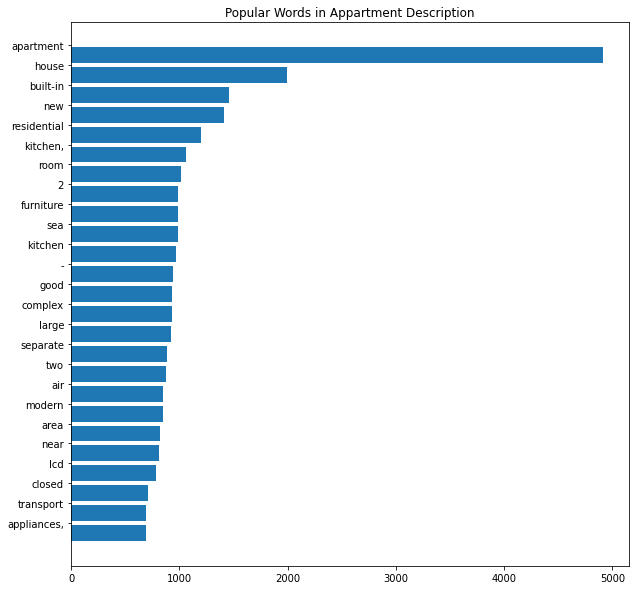

In [280]:
plt.figure(figsize=(10,10))
wordBarGraphFunction(df,'desc',"Popular Words in Appartment Description")

In [281]:
df_2['desc_len'] = df_2['desc'].apply(lambda x: len(str(x)))
df_2["desc"] = df_2["desc"].apply(lambda text: remove_punctuation(text))
df_2["desc"] = df_2["desc"].apply(lambda text: lemmatize_words(text))
df_2['near_sea']=df_2['desc'].str.contains('sea').astype(int)
df_2['near_school']=df_2['desc'].str.contains('school').astype(int)
df_2['near_kindergarten']=df_2['desc'].str.contains('kindergarten').astype(int)          
df_2['near_park']=df_2['desc'].str.contains('park').astype(int)
df_2['parking']=df_2['desc'].str.contains('parking').astype(int)
df_2['new']=df_2['desc'].str.contains('new').astype(int)
df_2['with_builtin']=df_2['desc'].str.contains('built-in').astype(int)
df_2['with_kitchen']=df_2['desc'].str.contains('kitchen,', 'kitchen').astype(int)
df_2['with_furniture']=df_2['desc'].str.contains('furniture,', 'furniture').astype(int)
df_2['after_renovation']=df_2['desc'].str.contains('renovation', 'renovated').astype(int)
df_2['large']=df_2['desc'].str.contains('large', 'spacious').astype(int)
df_2['good']=df_2['desc'].str.contains('good', 'excellent').astype(int)
df_2['modern']=df_2['desc'].str.contains('modern').astype(int)
df_2.drop('desc', axis=1, inplace=True)

So, from one feature we get 16 new

We measure the result of our actions:

In [282]:

model_score(df_2)

*************OUTLIERS TO DROP***************
         price  rooms  floor  floors   area
4174  350000.0      4     23      24  215.9
Outliers dropped
         price  rooms  floor  floors   area
815   135000.0      3     22      23  148.0
5889  236040.0      3     20      20  167.2
3739  130000.0      5     20      20  155.0
6098  183750.0      3     26      26  147.0
Outliers dropped
*************MODELS RESULT******************
GB MAE for test DF: 17137.989
LR MAE for test DF: 23437.894
RF MAE for test DF: 15995.496
********************************************


We managed to improve the result by only 1%, and I decided to abandon the previous step. This is unlikely to improve our model.

I remove the descriptive feature from the dataset, since its transformation and use in modeling does not affect the further result

In [283]:
df.drop('desc', axis=1, inplace=True)

At this stage, I want to include new features in the dataset. They are based on existing features:

In [284]:
df_3 = df.copy()

#some mixed features  creation based on numerical features like as polynomial features, sqrt, log, exp
for i in df_3.drop('price', axis=1).columns:
    
    df_3[i+'**2'] = df_3[i]**2
    df_3[i+'sqrt'] = np.sqrt(df_3[i])
    df_3[i+'log']=df_3[i].apply(lambda x: 0 if (x == 0) else (-np.log(-x) if x < 0 else np.log(x)))

#new features based on rooms number
df_3['is_one_room'] = df_3['rooms'].map(lambda x: 1 if x == 1 else 0)
df_3['is_two_rooms'] = df_3['rooms'].map(lambda x: 1 if x == 2 else 0)
df_3['is_three_rooms'] = df_3['rooms'].map(lambda x: 1 if x == 3 else 0)
df_3['is_four_rooms'] = df_3['rooms'].map(lambda x: 1 if x == 4 else 0)
df_3['is_five_rooms'] = df_3['rooms'].map(lambda x: 1 if x == 5 else 0)
df_3['is_six_rooms'] = df_3['rooms'].map(lambda x: 1 if x == 6 else 0)

#new features based on floor number
df_3['is_first_floor'] = df_3['floor'].map(lambda x: 1 if x == 1 else 0)
df_3['is_second_floor'] = df_3['floor'].map(lambda x: 1 if x == 2 else 0)
df_3['is_third_floor'] = df_3['floor'].map(lambda x: 1 if x == 3 else 0)
df_3['more_10_floor'] = df_3['floor'].map(lambda x: 1 if x >=10 else 0)
# new features based on floors number
df_3['is_one_floor'] = df_3['floors'].map(lambda x: 1 if x == 1 else 0)
df_3['upto_5_floors'] = df_3['floors'].map(lambda x: 1 if (x> 1) and (x <= 5) else 0)
df_3['upto_9_floors'] = df_3['floors'].map(lambda x: 1 if (x> 5) and (x <= 9) else 0)
df_3['upto_16_floors'] = df_3['floors'].map(lambda x: 1 if (x>9) and (x <= 16) else 0)
df_3['more_16_floors'] = df_3['floors'].map(lambda x: 1 if x > 16 else 0)
# new features based on area of appartment
df_3['small_area'] = df_3['area'].map(lambda x: 1 if x<=42.5 else 0)
df_3['medium_area'] = df_3['area'].map(lambda x: 1 if (x> 42.5) and (x <= 76) else 0)
df_3['large_area'] = df_3['area'].map(lambda x: 1 if (x>76) and (x <= 115) else 0)
df_3['very_large_area'] = df_3['area'].map(lambda x: 1 if x > 115 else 0)


In [285]:
model_score(df_3)

*************OUTLIERS TO DROP***************
         price  rooms  floor  floors   area
4174  350000.0      4     23      24  215.9
Outliers dropped
         price  rooms  floor  floors   area
815   135000.0      3     22      23  148.0
5889  236040.0      3     20      20  167.2
3739  130000.0      5     20      20  155.0
6098  183750.0      3     26      26  147.0
Outliers dropped
*************MODELS RESULT******************
GB MAE for test DF: 16643.146
LR MAE for test DF: 19245.835
RF MAE for test DF: 16012.477
********************************************


This step also did not improve the result of the model. I decided not to include new features in the dataset

Let's save our memory:

In [286]:
df_0 = df_0.iloc[0:0]
df_1 = df_1.iloc[0:0]
df_2 = df_2.iloc[0:0]
df_3 = df_3.iloc[0:0]

Preliminary results: we inserted missing feature values, encoded them, introduced some new features, but the result is not satisfactory. Go ahead.

First of all, let's take a look at feature distribution charts.

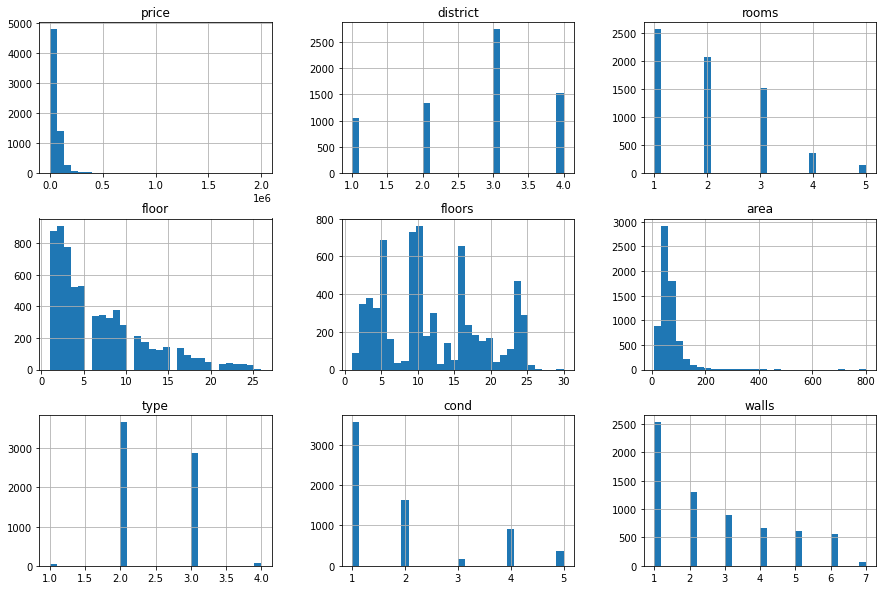

In [287]:
# some visualisations of features
df_hist = df.select_dtypes(exclude = ['bool','object'])
df_hist.hist(figsize = [15,10],bins = 30)
plt.show()

Let's take a closer look at the combination of area and price features in a graphical form:

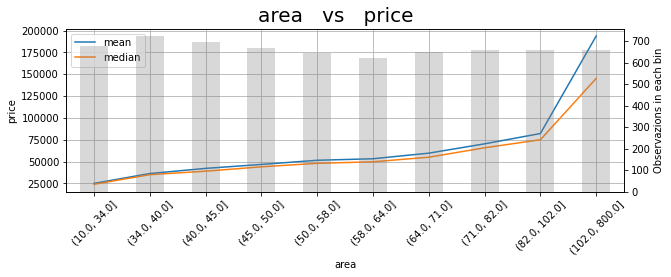

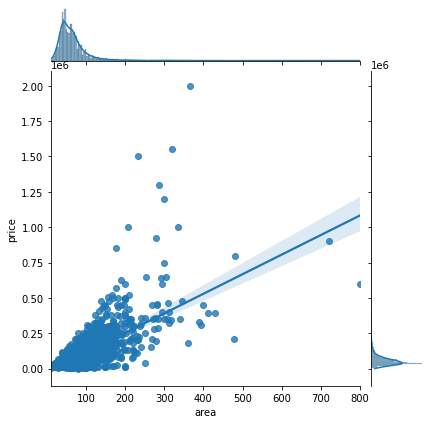

In [288]:
x, y = "area", "price"
### bin plot    
df_noNan = df[df[x].notnull()]    
breaks = np.quantile(df_noNan[x], q=np.linspace(0, 1, 11))    
groups = df_noNan.groupby([pd.cut(df_noNan[x], bins=breaks,     
           duplicates='drop')])[y].agg(['mean','median','size'])    
fig, ax = plt.subplots(figsize=(10,3))    
fig.suptitle(x+"   vs   "+y, fontsize=20)    
groups[["mean", "median"]].plot(kind="line", ax=ax)    
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,    
                    color="grey", alpha=0.3, grid=True)    
ax.set(ylabel=y)    
ax.right_ax.set_ylabel("Observazions in each bin")    
plt.show()
### scatter plot    
sns.jointplot(x=x, y=y, data=df, dropna=True, kind='reg')    
plt.show()

And with detailing by city districts:

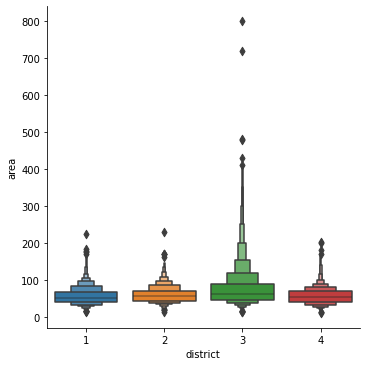

In [289]:
sns.catplot(x="district", y="area", data=df, kind="boxen")


Separately it should be said about the Primorsky district, it is encoded with the number 3. There is a big difference in prices for it, since the district is the most densely populated in the city.

We can observe that these characteristics have a lot of emissions, as well as the fact that when the threshold value of living area of 102 square meters is exceeded, the degree of its impact on the target characteristic increases significantly.

In [290]:
df.area.describe(percentiles=[.25, .5, .75, .89]).T

count    6657.000000
mean       65.467633
std        39.347797
min        10.000000
25%        42.600000
50%        58.000000
75%        75.500000
89%       100.000000
max       800.000000
Name: area, dtype: float64

This suggests that 89% of the objects in our dataset have an area not exceeding the specified threshold value. And I decide to make an image of the dataset by the area value - up to 100 square meters.

Since the main amount of outliers falls on the district marked 3, we remove them according to the previously selected strategy, exactly in accordance with this district.

In [291]:
for x in df.index:
  if df.loc[x, "district"] == 3 and df.loc[x, "area"] > 100 :
      df.drop(x, inplace = True)

After trimming it will look like this:

<AxesSubplot:label='76df41a8-364f-4c30-ad5f-64c1f3475586'>

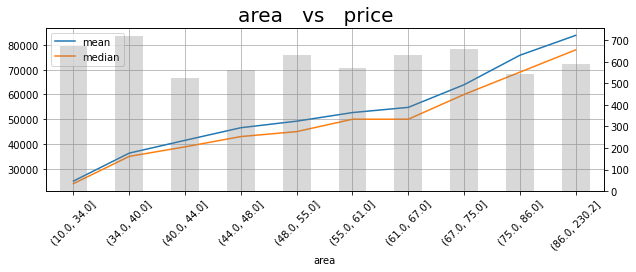

In [292]:
x, y = "area", "price"
### bin plot    
df_noNan = df[df[x].notnull()]    
breaks = np.quantile(df_noNan[x], q=np.linspace(0, 1, 11))    
groups = df_noNan.groupby([pd.cut(df_noNan[x], bins=breaks,     
           duplicates='drop')])[y].agg(['mean','median','size'])    
fig, ax = plt.subplots(figsize=(10,3))    
fig.suptitle(x+"   vs   "+y, fontsize=20)    
groups[["mean", "median"]].plot(kind="line", ax=ax)    
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,    
                    color="grey", alpha=0.3, grid=True)    


In [293]:
model_score(df)

*************OUTLIERS TO DROP***************
         price  rooms  floor  floors   area
6670  115000.0      3     25      25  123.0
Outliers dropped
         price  rooms  floor  floors   area
3199  160000.0      5      9      10  178.0
2438  110000.0      4     16      16  170.0
780   180000.0      5     16      18  171.0
3514  250000.0      5     14      15  202.0
1294  165000.0      4      6       8  142.0
6698  110000.0      4     21      24  115.0
Outliers dropped
*************MODELS RESULT******************
GB MAE for test DF: 9480.033
LR MAE for test DF: 14912.231
RF MAE for test DF: 9248.208
********************************************


Our MAE result immediately improved by over 40%. 

I could stop there, but I propose to take a look at the outliers of the target feature. Perhaps we will see something useful here:

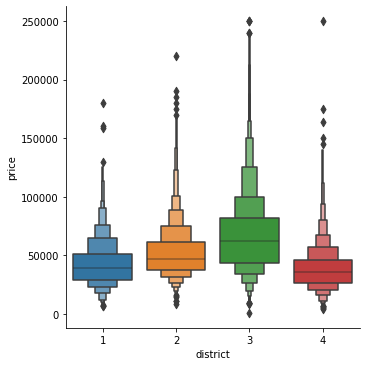

In [294]:
sns.catplot(x="district", y="price", data=df, kind="boxen")


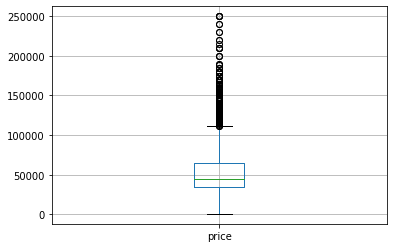

In [295]:
boxplot = df.boxplot(column=['price'])

In [296]:
df.price.describe(percentiles=[.25, .5, .75, .94]).T

count      6118.000000
mean      52304.940854
std       28989.278679
min         550.000000
25%       34000.000000
50%       45000.000000
75%       65000.000000
94%      100000.000000
max      250000.000000
Name: price, dtype: float64

I also see a lot of outliers here. I think that we can painlessly trim the dataset at the $ 100,000 housing cost threshold, which will allow us to describe 94% of the dataset.

In [297]:
df= df[(df.price<100000)&(df.price>550)].reset_index(drop=True)


In [298]:
model_score(df)

*************OUTLIERS TO DROP***************
Empty DataFrame
Columns: [price, rooms, floor, floors, area]
Index: []
Outliers dropped
Empty DataFrame
Columns: [price, rooms, floor, floors, area]
Index: []
Outliers dropped
*************MODELS RESULT******************
GB MAE for test DF: 6932.639
LR MAE for test DF: 11040.203
RF MAE for test DF: 6716.467
********************************************


Great result: we improved our model's margin of error from the initial USD 17,400 to the final USD 6,716

And one more thing: getting dummies from District feature. Let's see how it can improve our result..

In [299]:
df = pd.get_dummies(df, columns=['district'])

In [300]:
model_score(df)

*************OUTLIERS TO DROP***************
Empty DataFrame
Columns: [price, rooms, floor, floors, area]
Index: []
Outliers dropped
Empty DataFrame
Columns: [price, rooms, floor, floors, area]
Index: []
Outliers dropped
*************MODELS RESULT******************
GB MAE for test DF: 6829.444
LR MAE for test DF: 9330.883
RF MAE for test DF: 6558.797
********************************************


I do not want to stop there and for a better model I propose to optimize the hyperparameters

{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.95, 'max_features': 5, 'max_depth': 19}
************OPTIMAL RANDOM FOREST MODEL RESULT***********
RF optimized MAE for test DF: 6500.670
***************************************


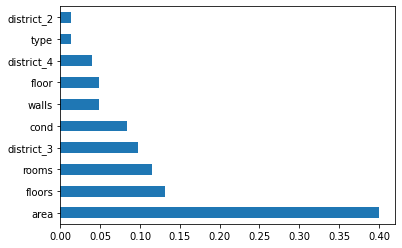

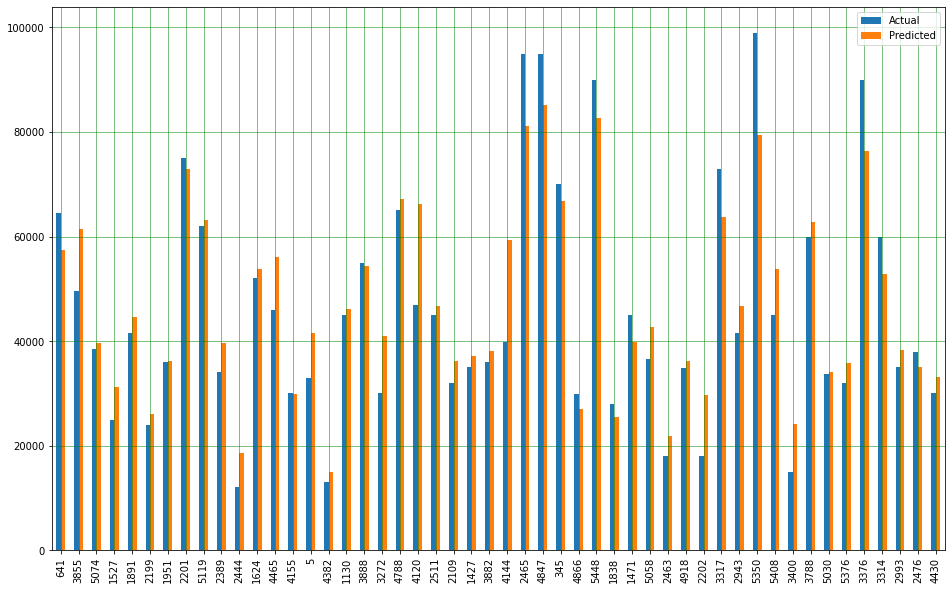

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=19, max_features=5, max_leaf_nodes=None,
                      max_samples=0.95, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=180, n_jobs=None, oob_score=False,
                      random_state=2020, verbose=0, warm_start=False)

In [305]:

rf_best_score(df)


Conclusions:

- in this project, I was able to process the initial data and build a training model that can reduce the minimum absolute error from USD 17,460 to USD 6,500 (almost 2.5 times)

- the main contribution to the predictive ability of the model is made by the area indicator - it justifies about 45 % of the result

- an additional 30 % of the result in equal proportions justify the indicators of the number of floors of the building and the district in which the object is located

- another 15 % substantiate indicators of the condition of the object and the number of its rooms

- and finally, about 10 % of the model's effectiveness is influenced by such indicators as the floor and the material of the walls. The project type indicator did not play an important role.



- a model based on numerological features without taking into account missing values at the initial stage gave a base result of USD 17469 as MAE, which had to be improved in the next steps

- after imputing the missing values and encoding them, I got the MAE result of 16093 , reducing the mean absolute error value almost 10%

- production of new features on the basis of existing ones, including on the basis of a descriptive feature, as a result of the transformation of which 16 new ones were obtained - did not result in error reduction

- then it was decided to remove outliers of area values of objects located in the Primorsky district of the city - this led to a decrease in the error by 42% to the level of USD 9,248

- after trimming the dataset by price of objects on level USD 100,000 (94% of real estate objects are within this limit), I received an MAE result of USD 6,753, reducing its level by 27% compared to the previous stage

- after optimizing the hyperparameters of the model at the final stage, the MAE USD 6,596 result was obtained 

- thus I was able to reduce MAE from 17469 to 6500 while reducing the number of dataset objects from 6657 to 5731 (13%)
